[Overture Maps Foundation](https://overturemaps.org/) is an open source effort publishing a wealth of information helpful to our efforts in `wombat`. The latest release was June, 2023. Although one can query the dataset via AWS CLI etc. as per their documentation, it is easier to download the entire dataset (200GB) as a set of Apache Spark pyarrow objects and query those directy with DuckDB. The following script is what was used to extract out specific regions for `wombat`. Special thanks to [Simon Willison's Post](https://til.simonwillison.net/overture-maps/overture-maps-parquet).

In [205]:
%load_ext autoreload
%autoreload 2
import duckdb
import pandas as pd
import time
import glob
import os
import geopandas as gpd
from shapely import wkt,wkb
from shapely.geometry import Polygon
import json
import matplotlib.pylab as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
# define functions

def timer_decorator(func):
    """Decorator that measures the execution time of a function.
    
    Args:
        func (function): The function to be decorated.
    
    Returns:
        function: The decorated function.
    
    Example:
        @timer_decorator
        def my_function():
            # code here
    """
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        days, remainder = divmod(elapsed_time, 86400)
        hours, remainder = divmod(remainder, 3600)
        minutes, seconds = divmod(remainder, 60)

        print(f"Function {func.__name__} took {int(days)} day(s), {int(hours)} hour(s), {int(minutes)} minute(s) and {seconds:.2f} second(s) to run.")
        return result
    return wrapper


def filter_small_within_large(small_gdf, large_gdf):
    """Filters buildings based on their location within states.
    
    Args:
        small_gdf (geopandas.GeoDataFrame): A GeoDataFrame containing e.g. buildings.
        large_gdf (geopandas.GeoDataFrame): A GeoDataFrame containing e.g. states.
    
    Returns:
        geopandas.GeoDataFrame: A GeoDataFrame containing the filtered small objects.
    """
   
   # If the CRS for both GeoDataFrames doesn't match,
   # convert small_gdf crs to large_gdf crs
 
    if small_gdf.crs != large_gdf.crs:
        large_gdf = large_gdf.to_crs(small_gdf.crs)

    joined = gpd.sjoin(small_gdf, large_gdf, op='within')
   
    return joined[small_gdf.columns]

def convert_raw_overture(df):
    """Converts a raw Overture DataFrame to a GeoDataFrame.
    
    Args:
        df (pandas.DataFrame): The raw Overture DataFrame.
    
    Returns:
        gdf (geopandas.GeoDataFrame): The converted GeoDataFrame.
    """
    gdf = gpd.GeoDataFrame(df)
    gdf['wkb_geometry'] = gdf['geometry'].copy()

    # Convert the WKB geometry column to Shapely geometries
    gdf['geometry'] = gdf['wkb_geometry'].apply(lambda x: wkb.loads(x, hex=True))

    # Drop the WKB geometry column
    gdf = gdf.drop(columns=['wkb_geometry'])

    # unpack
    gdf = gdf.set_geometry('geometry')
    gdf = gdf.set_crs("EPSG:4283")
    return gdf

def unpack_column(data):
    """Unpacks a column of data into a dictionary.
    
    Args:
        data: The data to be unpacked. It can be either a dictionary or a list of dictionaries.
    
    Returns:
        A dictionary containing the unpacked data.
    
    Example:
        data = [{'key': ['locality', 'postcode', 'freeform', 'region', 'country'], 
                 'value': ['Darwin', '0820', '85 May St', 'NT', 'AU']}]
        unpack_column(data)  # Returns {'locality': 'Darwin', 'postcode': '0820', 'freeform': '85 May St', 'region': 'NT', 'country': 'AU'}
    """
    if data is None:
        return None
    
    # Example unpacking
    #data = [{'key': ['locality', 'postcode', 'freeform', 'region', 'country'], 
    #         'value': ['Darwin', '0820', '85 May St', 'NT', 'AU']}]

    # Get the list of dictionaries
    if type(data) is dict:
        list_of_dict = data['value'][0]
    else:
        list_of_dict = data[0]
    
    # Use zip function to pair each key with its corresponding value
    zipped_pairs = zip(list_of_dict['key'], list_of_dict['value'])

    # Convert zipped_pairs into a dictionary using dictionary comprehension
    dict_result = {k:v for k, v in zipped_pairs}
    return dict_result

def postprocess_pois(gdf):
    """Postprocesses the given GeoDataFrame by extracting specific values from nested columns and merging additional dataframes.
    
    Args:
        gdf (GeoDataFrame): The input GeoDataFrame.
    
    Returns:
        GeoDataFrame: The postprocessed GeoDataFrame.
    """
    gdf['names'] = gdf['names'].apply(lambda x: x['value'][0][0]['value'][0])
    gdf['websites'] = gdf['websites'].apply(lambda x: x[0] if x is not None else None)
    gdf['socials'] = gdf['socials'].apply(lambda x: x[0] if x is not None else None)
    gdf['emails'] = gdf['emails'].apply(lambda x: x[0] if x is not None else None)
    gdf['phones'] = gdf['phones'].apply(lambda x: x[0] if x is not None else None)
    gdf['categories_main'] = gdf['categories'].apply(lambda x: x['main'] if "alternate" in x.keys() and x['main'] is not None else None)
    gdf['categories_alternate'] = gdf['categories'].apply(lambda x: x['alternate'][0] if "alternate" in x.keys() and x['alternate'] is not None else None)
    
    #brands = pd.json_normalize(gdf['brands'].apply(unpack_column))
    #gdf = pd.merge(gdf,brands,left_index=True,right_index=True)
        
    sources = pd.json_normalize(gdf['sources'].apply(unpack_column))
    gdf = pd.merge(gdf,sources,left_index=True,right_index=True)
    
    addresses = pd.json_normalize(gdf['addresses'].apply(unpack_column))
    gdf = pd.merge(gdf,addresses,left_index=True,right_index=True)
    
    gdf = gdf.drop(columns=['addresses','categories','sources','brand'])
    return gdf

def postprocess_buildings(gdf):
    """Postprocess the buildings GeoDataFrame.
    
    Args:
        gdf (GeoDataFrame): The input GeoDataFrame containing buildings data.
    
    Returns:
        GeoDataFrame: The processed GeoDataFrame with the following modifications:
            - The 'names' column is updated to only contain the 'value' field of each name.
            - The 'sources' column is unpacked and merged into separate columns.
            - The 'sources' column is dropped from the GeoDataFrame.
    """
    #gdf['names'] = gdf['names'].apply(lambda x: x[0]['value'][0] if x is not None and len(x[0]['value']) != 0 else None)
    gdf['names'] = gdf['names'].apply(take_first_name)
    sources = pd.json_normalize(gdf['sources'].apply(unpack_column))
    gdf = pd.merge(gdf,sources,left_index=True,right_index=True)
    
    gdf = gdf.drop(columns=['sources'])
    return gdf

def generate_bbox_query(datapath,datatype,minx, maxx, miny, maxy):
    """Generates a SQL query string to retrieve data from a Parquet file based on the specified bounding box.
    
    Args:
        datatype (str): The datatype of the data to retrieve.
        minx (float): The minimum x-coordinate of the bounding box.
        maxx (float): The maximum x-coordinate of the bounding box.
        miny (float): The minimum y-coordinate of the bounding box.
        maxy (float): The maximum y-coordinate of the bounding box.
    
    Returns:
        str: The SQL query string.
    
    Example:
        query = generate_bbox_query('example', 0.0, 10.0, 0.0, 10.0)
        print(query)
        # Output: SELECT *
        #         from read_parquet('E:/overture/theme=buildings/type=*/*')
        #         where
        #         bbox.minx >= 0.0
        #         and bbox.maxx <= 10.0
        #         and bbox.miny >= 0.0
        #         and bbox.maxy <= 10.0
    """

    datapath_theme = os.path.join(datapath, f'theme={datatype}', 'type=*','*')

    query_str = f"""
            SELECT *
            from read_parquet('{datapath_theme}')
            where
            bbox.minx >= {minx}
            and bbox.maxx <= {maxx}
            and bbox.miny >= {miny}
            and bbox.maxy <= {maxy}
            """
    return query_str


def take_first_name(dict_obj):
    """Return the first name from a dictionary object.
    
    Args:
        dict_obj (dict): A dictionary object.
    
    Returns:
        str or None: The first name from the dictionary object, or None if the required keys are missing or have no values.
    
    Example:
        >>> dict_obj = {'key': 'name', 'value': [{'value': ['John', 'Doe']}, {'value': ['Jane', 'Smith']}, {'value': ['Alice', 'Johnson']}]}
        >>> take_first_name(dict_obj)
        'John'
    """
    # Check if keys 'key' and 'value' exist and they have values
    if dict_obj.get('key') and dict_obj.get('value'):
        value_list = dict_obj['value']
        #print(value_list)
        for v in value_list:
            return v[0].get('value')[0]
    return None


In [4]:
db = duckdb.connect()
db.execute("INSTALL spatial")
db.execute("INSTALL httpfs")
db.execute("""
            LOAD spatial;
            LOAD httpfs;
            """)

def run_query(query_str,fout,poly_wkt=None):
    print(query_str)
    
    # create cursor
    if "poly" in query_str:
        cursor = db.execute(query_str,{"poly_wkt": poly_wkt})
    else:
        cursor = db.execute(query_str)
        
    print("Fetching data...")
    rows = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    dicts = [dict(zip(columns, row)) for row in rows]
    
    df = pd.DataFrame(dicts)
    print("Number of objects found:",df.shape[0])
    
    return df


## Define Bounding Box For Objects To Be Extracted

In [275]:
# You can define any bounding box you like, but we're using wombat's convenient boundaries here

# initialise wombat!
%load_ext autoreload
%autoreload 2
import wombat
w = wombat.Wombat()

w.set_area_as_country()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


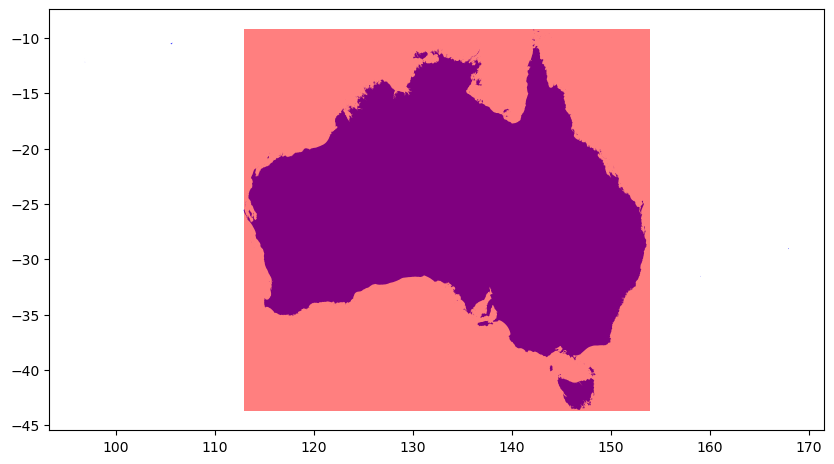

In [278]:
# Let's just double check that the bounding box covers Australia
fig, ax = plt.subplots(figsize=(10,10))
w.Boundary.gdf.plot(ax=ax, color='blue')
w.Boundary.Australia_BoundingBox_Poly.plot(ax=ax, color='red', alpha=0.5)
plt.show()

In [287]:
# get the bounds for all of Australia 
# (fortunately, the bounding box mostly will only cover Australia)
# these bounds will be used for the query for Overture

# Get the bounding box parameters of the above
minx,miny,maxx,maxy = w.Boundary.Australia_BoundingBox_Poly.iloc[0].geometry.bounds
print(minx,miny,maxx,maxy)

112.9519424 -43.7405093 153.9933464 -9.1870234


## Bringing It All Together

In [292]:

categories = ["places","buildings"]

datapath="E:\\overture\\"
fout="overture-australia2.gpkg"

for category in categories:
    print("Finding:",category)
    # create query string
    query_str = generate_bbox_query(datapath,
                                    category,
                                    minx,
                                    maxx,
                                    miny,
                                    maxy)
    
    # execute query
    df_overture = run_query(query_str,fout)
    
    if df_overture.shape[0] == 0:
        print("NO OBJECTS FOUND")
        sys.exit()
        
    # convert dataframe into geopandas
    gdf_overture = convert_raw_overture(df_overture)
    
    # get only those within polygon of Australia
    filtered_gdf = filter_small_within_large(gdf_overture,w.Boundary.Australia_BoundingBox_Poly)
    
    # save to file
    if category == "places":
        pgdf = postprocess_pois(filtered_gdf)
    elif category == "buildings":
        pgdf = postprocess_buildings(filtered_gdf)
        
    if fout is not None and not os.path.exists(fout):
        print("> SAVING:",fout)
        pgdf.to_file(os.path.join(datapath,fout), driver="GPKG",layer=category)


Finding: places

            SELECT *
            from read_parquet('E:\overture\theme=places\type=*\*')
            where
            bbox.minx >= 112.9519424
            and bbox.maxx <= 153.9933464
            and bbox.miny >= -43.7405093
            and bbox.maxy <= -9.1870234
            
Fetching data...
Number of objects found: 997465
Finding: buildings

            SELECT *
            from read_parquet('E:\overture\theme=buildings\type=*\*')
            where
            bbox.minx >= 112.9519424
            and bbox.maxx <= 153.9933464
            and bbox.miny >= -43.7405093
            and bbox.maxy <= -9.1870234
            
Fetching data...
Number of objects found: 12074506


In [ ]:
pgdf.head()

## Check Extracted Overture Objects (Buildings & POIs)

In [ ]:
import math
import  shapely

def get_bounding_box(latitude, longitude, distance_in_kms):
    """Calculate the bounding box coordinates based on a given latitude, longitude, and distance in kilometers.
    
    Args:
        latitude (float): The latitude of the center point.
        longitude (float): The longitude of the center point.
        distance_in_kms (float): The distance in kilometers to calculate the bounding box.
    
    Returns:
        tuple: A tuple containing the minimum and maximum longitude and latitude coordinates of the bounding box in decimal degrees. The order of the coordinates is (lon_min, lat_min, lon_max, lat_max).
    """
    # Earth’s radius, sphere
    R = 6378137

    # Offsets in meters
    dn = distance_in_kms*1000.
    de = distance_in_kms*1000.

    # Coordinate offsets in radians
    dLat = dn / R
    dLon = de / (R * math.cos(math.pi * latitude / 180))

    # OffsetPosition, decimal degrees
    lat_min = latitude - dLat * 180/math.pi
    lon_min = longitude - dLon * 180/math.pi
    lat_max = latitude + dLat * 180/math.pi
    lon_max = longitude + dLon * 180/math.pi
    
    return lon_min, lat_min, lon_max, lat_max

def filter_gdf_center_width(gdf,width,center):
    """Filters a GeoDataFrame based on a specified width and center point.
    
    Args:
        gdf (GeoDataFrame): The GeoDataFrame to be filtered.
        width (float): The width of the bounding box.
        center (tuple): The center point of the bounding box in the format (x, y).
    
    Returns:
        GeoDataFrame: The filtered GeoDataFrame based on the specified width and center point.
    """
    minx, miny, maxx, maxy = get_bounding_box(center[0],center[1],width)
    return filter_gdf_bbox(gdf,minx, miny, maxx, maxy)

def filter_gdf_bbox(gdf, minx, miny, maxx, maxy):
    """Filters a GeoDataFrame based on a bounding box.
    
    Args:
        gdf (GeoDataFrame): The GeoDataFrame to be filtered.
        minx (float): The minimum x-coordinate of the bounding box.
        miny (float): The minimum y-coordinate of the bounding box.
        maxx (float): The maximum x-coordinate of the bounding box.
        maxy (float): The maximum y-coordinate of the bounding box.
    
    Returns:
        GeoDataFrame: The filtered GeoDataFrame containing only the geometries that intersect with the bounding box.
    """
    bbbox = geometry.box(minx, miny, maxx, maxy)
    return gdf[gdf.geometry.intersects(bbbox)]

In [ ]:
# define center
center_latlon = [153.000433,-27.401064]

# define width
bbox_width = 2 #kms

# get structures within Australia wide dataframe
buildings_gdf_filter = filter_gdf_center_width(w.Buildings.buildings_gdf_combined,width=bbox_width,center=center_latlon)

lon_min, lat_min, lon_max, lat_max = get_bounding_box(center_latlon[0],center_latlon[1],bbox_width)

m.add_gdf(buildings_gdf_filter,layer_name='Microsoft', style={'color': 'black','fillOpacity':0},hover_style={'color': 'red','fillOpacity':0})
m